In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
import math
from scipy.signal import find_peaks

In [4]:
N = 5
L =  np.array([[2*np.pi*np.random.uniform() for x in range(N)] for y in range(N)]) # ask
p_0 = np.random.normal(size=(N,N))
J = 1
beta = 1.0

In [5]:
# Defining the Hamiltonian XY model

def Hamiltonian2D(J, L):
    Hamiltonian2D = 0.
    n = np.shape(L)[0]
    for x in range (np.shape(L)[0]):
        for y in range (np.shape(L)[0]):
            Hamiltonian2D -= J * ((np.cos(L[x, y] - L[x, (y+1)%n])) + (np.cos(L[x, y] - L[x, (y-1)%n])) 
                                  + (np.cos(L[x, y] - L[(x+1)%n, y])) + (np.cos(L[x, y] - L[(x-1)%n, y])))
    
    
    return Hamiltonian2D/2


In [6]:
# Defining the artifical Hamiltonian XY model

def Hamiltonian2D_art(J, L, P, beta):
    n = np.shape(L)[0]
    Hamiltonian2D_art = sum(sum(P**2))/2 + beta*Hamiltonian2D(J, L)
    return Hamiltonian2D_art

# print(Hamiltonian2D_art(1, L, 1, 1 ))

In [7]:
# Defining the equations of motion

def P_dot_i_2D(J, L):
    n = np.shape(L)[0]
    P_dot_i_2D = np.zeros((n,n))

    for x in range (np.shape(L)[0]):
        for y in range (np.shape(L)[0]):
            P_dot_i_2D[x,y] -= J * ((np.sin(L[x, y] - L[x, (y+1)%n])) + (np.sin(L[x, y] - L[x, (y-1)%n])) 
                                    + (np.sin(L[x, y] - L[(x+1)%n, y])) + (np.sin(L[x, y] - L[(x-1)%n, y])))
    return P_dot_i_2D*beta*J


In [8]:
# Leapfrog integrator

def leapfrog_2D(N_md, p_0,J, L): 
    epsilon = 1/N_md
    p = np.copy(p_0)
    L_new = np.copy(L)
    L_new += p*epsilon/2

    for i in range(N_md-1):
        p += P_dot_i_2D(J, L_new)*epsilon
        L_new += p*epsilon

    
    p +=  P_dot_i_2D(J, L_new)*epsilon
    L_new -= p*epsilon/2
    L_new = abs(L_new%(2*np.pi))
    return p, L_new



In [9]:
# Defining some variables


print(np.ndim(L))

2


In [10]:
# To see the convergence of leapfrog integrator


diff = []
range_1 =[i for i in range(10,500,10)]
p_0 = np.random.normal(size=(N,N))
for N_md in range_1:
   
    arr = leapfrog_2D(N_md, p_0, J,L)
    p_f = arr[0]          # We need final values of p_f and phi_f to calculate H_f
    Lat_ev = arr[1]
    H_f = Hamiltonian2D_art(J, Lat_ev, p_f, beta)
    H_0 = Hamiltonian2D_art(J, L, p_0, beta)
# dimension of L is 2 and p_0 
# The following is the quantity we want on y-axis
    diff.append(abs((H_f-H_0)/H_0)) 
    
# print(p_0)
# print(L)
# print(phi_f)

print("ini=",H_0)
print("final=",H_f)

ini= 14.330102909057393
final= 14.358631149560575


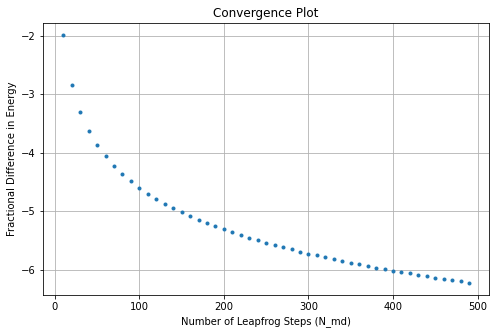

<Figure size 432x288 with 0 Axes>

In [15]:

plt.figure(figsize=(8,5))
plt.xlabel('Number of Leapfrog Steps (N_md)')
plt.ylabel('Fractional Difference in Energy')
plt.title('Convergence Plot')
plt.grid()
plt.plot(range_1, np.log(diff),'.')
# plt.yscale("log")
plt.show()
# plt.savefig("leap.pgf")
plt.savefig("leap.png")

In [12]:
# Now we code the HMC algorithm


def markov_chain(L_i,N_cfg,N_md,beta,J):
    
    M_arr=[]
    E_arr=[]
    E2_arr=[]
    M2_arr=[]

    # bin_length
    count=0
    for k in range(n_therm):
          
        p_hmc = np.random.normal(size=(N,N))
        new = leapfrog_2D(N_md, p_hmc,J, L_i) # Integrating leapfrog algorithm
        prob = np.exp(Hamiltonian2D_art(J,L_i,p_hmc,beta)-Hamiltonian2D_art(J,new[1],new[0],beta))
        if prob > np.random.uniform(0,1):   # Accept/reject
            L_i=new[1] 
                
                
        
    for i in range(N_cfg):
        m = 0.0
        E = 0.0
        m2=0.
        e2=0.
        for k in range(bin_length):
            
            p_hmc = np.random.normal(size=(N,N))
            new = leapfrog_2D(N_md, p_hmc,J, L_i) # Integrating leapfrog algorithm
            E_new=Hamiltonian2D_art(J,L_i,p_hmc,beta)
            E_old=Hamiltonian2D_art(J,new[1],new[0],beta)
            prob = np.exp(E_old-E_new)
#  Given probability distribution function defined above
            if prob > np.random.uniform(0,1):
                # print("selected")
                Mag=np.sqrt(np.sum(np.cos(new[1]))**2+np.sum(np.sin(new[1]))**2)/N**2
                En=Hamiltonian2D(J,new[1])/N**2
                count+=1
                m2+=Mag**2
                e2+=En**2
                m += Mag
                E += En

        
                L_i = new[1]

            else:
                Mag=np.sqrt(np.sum(np.cos(L_i))**2+np.sum(np.sin(L_i))**2)/N**2
                En=Hamiltonian2D(J,L_i)/N**2
                m2+=Mag**2
                e2+=En**2
                m += Mag
                E += En
            
        M_arr.append(m / bin_length)
        E_arr.append(E / bin_length)
        M2_arr.append(m2 / bin_length)
        E2_arr.append(e2 / bin_length)

                
    print("Acceptance rate", count / (N_cfg*bin_length))
    return M_arr,E_arr, M2_arr, E2_arr



In [13]:
n_therm = 1000
bin_length = 20
L_i = np.array([[2*np.pi*np.random.uniform() for x in range(N)] for y in range(N)])
N_cfg = 500
N_md = 30
J = 1.0
beta = 1.0
# M_arr,E_arr = markov_chain(L_i,N_cfg,N_md,beta,J)
# M_avg = np.mean(M_arr)
# E_avg = np.mean(E_arr)
# print(M_avg,E_avg)
M_arr,E_arr, M2_arr, E2_arr = markov_chain(L_i,N_cfg,N_md,beta,J)
M_avg = np.mean(M_arr)
E_avg = np.mean(E_arr)
print(M_avg,E_avg)

Acceptance rate 0.9153
0.7911110026143282 -1.3923610149841408


In [16]:
print(M_avg,E_avg)

0.7911110026143282 -1.3923610149841408


In [17]:
print(len(E_arr))

500


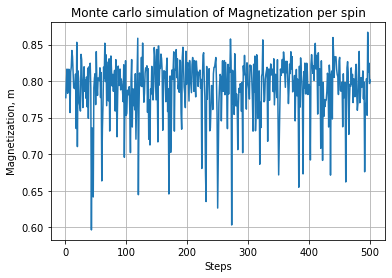

In [18]:
plt.plot(np.arange(1,501,1),M_arr)
plt.grid()
plt.xlabel("Steps")
plt.ylabel("Magnetization, m")
plt.title("Monte carlo simulation of Magnetization per spin")
plt.savefig("mcmc_mag.png")
# plt.savefig("mcmc_mag.pgf")

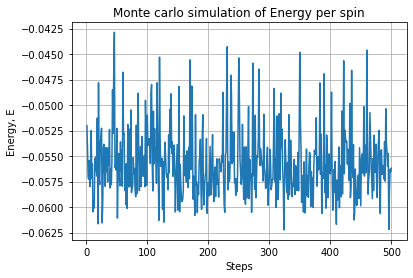

In [19]:
plt.plot(np.arange(1,501,1),np.array(E_arr)/N**2)
plt.grid()
plt.xlabel("Steps")
plt.ylabel("Energy, E")
plt.title("Monte carlo simulation of Energy per spin")
plt.savefig("mcmc_energy.png")
# plt.savefig("mcmc_mag.pgf")

# N = 5

In [46]:
N = 5
n_therm = 1000
bin_length = 30
L_i = np.array([[2*np.pi*np.random.uniform() for x in range(N)] for y in range(N)])
N_cfg = 200
N_md = 50
J = 1.0
T_arr = np.arange(0.1, 2.20, 0.20)
beta_arr=np.sort(1/T_arr)

E_means_5 = []
mag_means_5 = []

m_std_5 = []
E_std_5 = []

sus_5 = []
sus_5_std = []

heat_5 = []
heat_5_std = []


for beta in beta_arr:
    mag_5,E_5, M2_arr, E2_arr = markov_chain(L_i,N_cfg,N_md,beta,J) 
    
    k_5 = np.mean(np.array(mag_5))
    en_5 = np.mean(np.array(E_5))
    E_means_5.append(en_5)
    mag_means_5.append(k_5)
    
    
    m_std_5.append(np.std(mag_5))
    E_std_5.append(np.std(E_5))

    
    sus_5.append((np.mean( M2_arr) - np.square(np.mean(mag_5)))*beta*N**2)
    sus_5_std.append(np.std( M2_arr - np.square(mag_5)*beta*N**2))
    
    heat_5.append((np.mean(E2_arr) - np.square(np.mean(np.array(E_5))))*beta**2*N**2)
    heat_5_std.append(np.std((E2_arr - np.array(E_5)**2)*beta**2*N**2))



Acceptance rate 0.9721666666666666
Acceptance rate 0.9708333333333333
Acceptance rate 0.9655
Acceptance rate 0.9651666666666666
Acceptance rate 0.9546666666666667
Acceptance rate 0.95
Acceptance rate 0.9315
Acceptance rate 0.9335
Acceptance rate 0.905
Acceptance rate 0.8945
Acceptance rate 0.8436666666666667


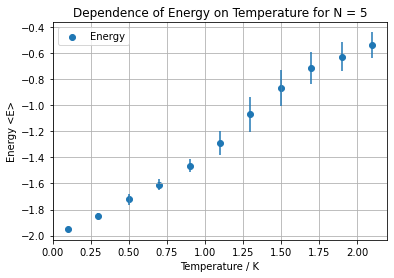

In [143]:
plt.scatter(T_arr[::-1], E_means_5,label="Energy")
plt.errorbar(T_arr[::-1], E_means_5, yerr=E_std_5, ls = "")
plt.grid()
plt.legend()
plt.xlabel("Temperature / K")
plt.ylabel("Energy <E>")
plt.title("Dependence of Energy on Temperature for N = 5")
plt.savefig("energy_5.png")

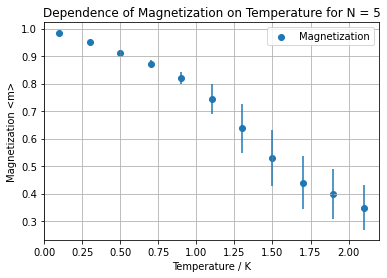

In [144]:
plt.scatter(T_arr[::-1],mag_means_5,label="Magnetization")
plt.errorbar(T_arr[::-1], mag_means_5, yerr=m_std_5,ls = "")
plt.grid()
plt.legend()
plt.xlabel("Temperature / K")
plt.ylabel("Magnetization <m>")
plt.title("Dependence of Magnetization on Temperature for N = 5")
plt.savefig("mag_5.png")

In [49]:
"FITTING STARTS HERE"

from lmfit import Model
# import lmfit as lm

def Lorentzian(x, amp1, cen1, wid1):
    return (amp1*wid1**2/((x-cen1)**2+wid1**2))

gmodel = Model(Lorentzian)

[[Model]]
    Model(Lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 58
    # data points      = 11
    # variables        = 3
    chi-square         = 0.02476894
    reduced chi-square = 0.00309612
    Akaike info crit   = -61.0566613
    Bayesian info crit = -59.8629755
[[Variables]]
    amp1:  0.57492778 +/- 0.04260603 (7.41%) (init = 0.25)
    cen1:  1.56810644 +/- 0.03474173 (2.22%) (init = 0.6)
    wid1: -0.46422383 +/- 0.05630930 (12.13%) (init = 0.15)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp1, wid1) = 0.710
    C(cen1, wid1) = -0.135


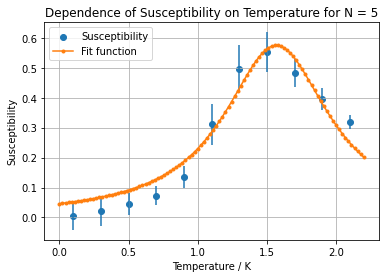

In [50]:
params_5 = gmodel.make_params(amp1=0.25, cen1=0.6, wid1=0.15)
result_5 = gmodel.fit(sus_5, params_5, x=T_arr[::-1])
print(result_5.fit_report())

beta_arr_cont= np.linspace(0,2.2,100)
fitted_func_5= Lorentzian(beta_arr_cont, result_5.params.valuesdict()['amp1'],
                         result_5.params.valuesdict()['cen1'],result_5.params.valuesdict()['wid1'])



plt.scatter(T_arr[::-1],sus_5,label="Susceptibility")
plt.errorbar(T_arr[::-1], sus_5, yerr=np.array(sus_5_std)/N**2,ls = "")
plt.plot(beta_arr_cont, fitted_func_5, '.-', label='Fit function')
plt.grid()
plt.legend()
# plt.xlabel("Beta (1/T)")
plt.xlabel("Temperature / K")
plt.ylabel("Susceptibility")
plt.title("Dependence of Susceptibility on Temperature for N = 5")
# plt.save()
plt.savefig("sus_5.png")


In [154]:


# params_5_heat = gmodel.make_params(amp1=0.5, cen1=0.72, wid1=0.05)
# result_5_heat = gmodel.fit(np.array(heat_5), params_5_heat, x=T_arr[::-1])
# print(result_5_heat.fit_report())

# beta_arr_cont= np.linspace(0.,2.2,100)
# fitted_func_5_heat= Lorentzian(beta_arr_cont, result_5_heat.params.valuesdict()['amp1'],
#                          result_5_heat.params.valuesdict()['cen1'],result_5_heat.params.valuesdict()['wid1'])


# plt.scatter(T_arr[::-1],heat_5,label="Specific Heat")
# plt.errorbar(T_arr[::-1], heat_5, yerr=np.array(heat_5_std)/N**2,ls = "")
# plt.plot(beta_arr_cont, fitted_func_5_heat, '.-', label='Fit Function')
# plt.grid()
# plt.legend()
# # plt.xlabel("Beta (1/(T)")
# plt.xlabel("Temperature / K")
# plt.ylabel("Specific Heat")
# plt.title("Dependence of Specific Heat on Temperature for N = 5")
# # # plt.save()
# plt.savefig("sp_heat_5.png")

[1.1038855  1.20741199 0.58496976]


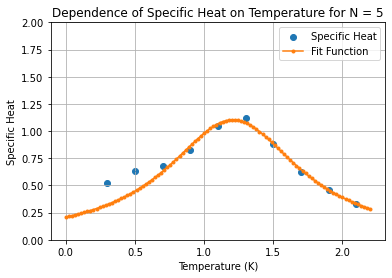

In [161]:
T_arr_new= T_arr[::-1]
popt5, cov5= curve_fit(Lorentzian, T_arr_new[T_arr_new>0.6], np.array(heat_5)[T_arr_new>0.6])
print(popt5)

beta_arr_cont= np.linspace(0,2.2,100)
fitted_func_5_heat= Lorentzian(beta_arr_cont, popt5[0],
                         popt5[1],popt5[2])

plt.scatter(T_arr_new[T_arr_new>0.25],np.array(heat_5)[T_arr_new>0.25],label="Specific Heat")
plt.errorbar(T_arr[::-1], heat_5, yerr=np.array(heat_5_std)/N**2,ls = "")
plt.plot(beta_arr_cont, fitted_func_5_heat, '.-', label='Fit Function')
plt.ylim(0,2)
plt.grid()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Specific Heat")
plt.title("Dependence of Specific Heat on Temperature for N = 5")
plt.savefig("sp_heat_5.png")

In [89]:
# x_5 = heat_5()[0.6:1]
# peaks, _ = find_peaks(x_5, height=0)

Considering the peak to be somewhere around 0.83, T = 1/0.83 = 1.204 in natural units where k_B = 1

But here the graph is not completely correct as we see that there is a secondary peak at the same y-axis level.

# N = 8

In [52]:
N = 8
n_therm = 1000
bin_length = 30
L_i = np.array([[2*np.pi*np.random.uniform() for x in range(N)] for y in range(N)])
N_cfg = 200
N_md = 50
J = 1.0
T_arr = np.arange(0.1, 2.20, 0.20)
beta_arr=np.sort(1/T_arr)

E_means_8 = []
mag_means_8 = []

m_std_8 = []
E_std_8 = []

sus_8 = []
sus_8_std = []

heat_8 = []
heat_8_std = []

L_i = np.array([[2*np.pi*np.random.uniform() for x in range(N)] for y in range(N)])

for beta in beta_arr:
    mag_8,E_8,M2_arr_8, E2_arr_8 = markov_chain(L_i,N_cfg,N_md,beta,J)
    

    k_8 = np.mean(np.array(mag_8))
    en_8 = np.mean(np.array(E_8))
    E_means_8.append(en_8)
    mag_means_8.append(k_8)
    
    m_std_8.append(np.std(mag_8))
    E_std_8.append(np.std(E_8))
    
    sus_8.append((np.mean( M2_arr_8) - np.square(np.mean(mag_8)))*beta*N**2)
    sus_8_std.append(np.std( M2_arr_8 - np.square(mag_8)*beta*N**2))
    
    heat_8.append((np.mean(E2_arr_8) - np.square(np.mean(np.array(E_8))))*beta**2*N**2)
    heat_8_std.append(np.std((E2_arr_8 - np.array(E_8)**2)*beta**2*N**2))

    
    

Acceptance rate 0.9593333333333334
Acceptance rate 0.9546666666666667
Acceptance rate 0.9536666666666667
Acceptance rate 0.9521666666666667
Acceptance rate 0.9383333333333334
Acceptance rate 0.9273333333333333
Acceptance rate 0.9195
Acceptance rate 0.8981666666666667
Acceptance rate 0.8778333333333334
Acceptance rate 0.8711666666666666
Acceptance rate 0.7058333333333333


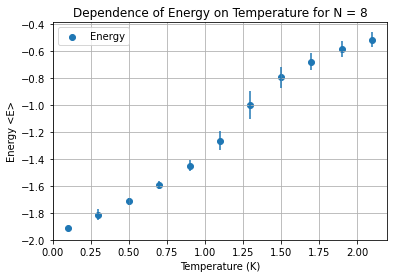

In [53]:
plt.scatter(T_arr[::-1], E_means_8,label="Energy")
plt.errorbar(T_arr[::-1], E_means_8, yerr=E_std_8, ls = "")
plt.grid()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Energy <E>")
plt.title("Dependence of Energy on Temperature for N = 8")
plt.savefig("energy_8.png")
# plt.savefig("energy_8.pgf")

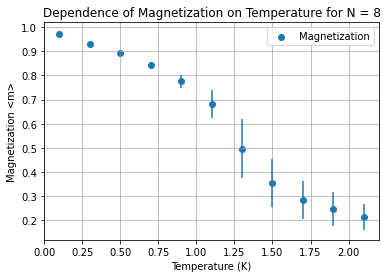

In [54]:
plt.scatter(T_arr[::-1],mag_means_8,label="Magnetization")
plt.errorbar(T_arr[::-1], mag_means_8, yerr=m_std_8,ls = "")
plt.grid()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Magnetization <m>")
plt.title("Dependence of Magnetization on Temperature for N = 8")
plt.savefig("mag_8.png")
# plt.savefig("mag_8.pgf")

[[Model]]
    Model(Lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 64
    # data points      = 11
    # variables        = 3
    chi-square         = 0.11992585
    reduced chi-square = 0.01499073
    Akaike info crit   = -43.7065465
    Bayesian info crit = -42.5128607
[[Variables]]
    amp1:  1.30536477 +/- 0.11714779 (8.97%) (init = 0.25)
    cen1:  1.39166153 +/- 0.02538280 (1.82%) (init = 0.6)
    wid1:  0.29854277 +/- 0.03957136 (13.25%) (init = 0.15)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp1, wid1) = -0.727


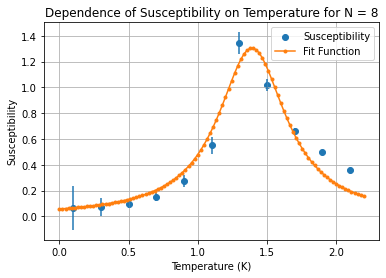

In [56]:

params_8 = gmodel.make_params(amp1=0.25, cen1=0.6, wid1=0.15)
result_8 = gmodel.fit(sus_8, params_8, x=T_arr[::-1])
print(result_8.fit_report())

beta_arr_cont= np.linspace(0,2.2,100)
fitted_func_8= Lorentzian(beta_arr_cont, result_8.params.valuesdict()['amp1'],
                         result_8.params.valuesdict()['cen1'],result_8.params.valuesdict()['wid1'])





plt.scatter(T_arr[::-1],sus_8,label="Susceptibility")
plt.errorbar(T_arr[::-1], sus_8, yerr=np.array(sus_8_std)/N**2,ls = "")
plt.plot(beta_arr_cont, fitted_func_8, '.-', label='Fit Function')
plt.grid()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Susceptibility")
plt.title("Dependence of Susceptibility on Temperature for N = 8")
plt.savefig("sus_8.png")
# plt.savefig("sus_8.pgf")

In [149]:

# params_8_heat = gmodel.make_params(amp1=0.5, cen1=0.72, wid1=0.05)
# result_8_heat = gmodel.fit(np.array(heat_8), params_8_heat, x=T_arr[::-1])
# print(result_8_heat.fit_report())

# beta_arr_cont= np.linspace(0,2.2,100)
# fitted_func_8_heat= Lorentzian(beta_arr_cont, result_8_heat.params.valuesdict()['amp1'],
#                          result_8_heat.params.valuesdict()['cen1'],result_8_heat.params.valuesdict()['wid1'])






# plt.scatter(T_arr[::-1],heat_8,label="Specific Heat")
# plt.errorbar(T_arr[::-1], heat_8, yerr=np.array(heat_8_std)/N**2,ls = "")
# plt.plot(beta_arr_cont, fitted_func_8_heat, '.-', label='Fit Function')

# plt.grid()
# plt.legend()
# plt.xlabel("Temperature (K)")
# plt.ylabel("Specific Heat")
# plt.title("Dependence of Specific Heat on Temperature for N = 8")
# plt.savefig("sp_heat_8.png")
# # plt.savefig("sp_heat_8.pgf")

[1.16840169 1.15065611 0.52108726]


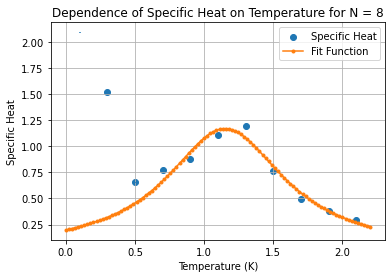

In [159]:
popt8, cov8= curve_fit(Lorentzian, T_arr_new[T_arr_new>0.6], np.array(heat_8)[T_arr_new>0.6])
print(popt8)

beta_arr_cont= np.linspace(0,2.2,100)
fitted_func_8_heat= Lorentzian(beta_arr_cont, popt8[0],
                         popt8[1],popt8[2])

plt.scatter(T_arr_new[T_arr_new>0.25],np.array(heat_8)[T_arr_new>0.25],label="Specific Heat")
plt.errorbar(T_arr[::-1], heat_8, yerr=np.array(heat_8_std)/N**2,ls = "")
plt.plot(beta_arr_cont, fitted_func_8_heat, '.-', label='Fit Function')
# plt.ylim(0,2)
plt.grid()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Specific Heat")
plt.title("Dependence of Specific Heat on Temperature for N = 8")
plt.savefig("sp_heat_8.png")

# N =10

In [58]:
N = 10
n_therm = 1000
bin_length = 30
L_i = np.array([[2*np.pi*np.random.uniform() for x in range(N)] for y in range(N)])
N_cfg = 200
N_md = 50
J = 1.0
T_arr = np.arange(0.1, 2.20, 0.20)
beta_arr=np.sort(1/T_arr)

E_means_10 = []
mag_means_10 = []

m_std_10 = []
E_std_10 = []

sus_10 = []
sus_10_std = []

heat_10 = []
heat_10_std = []

L_i = np.array([[2*np.pi*np.random.uniform() for x in range(N)] for y in range(N)])

for beta in beta_arr:
    mag_10,E_10,M2_arr_10, E2_arr_10 = markov_chain(L_i,N_cfg,N_md,beta,J)
    

    k_10 = np.mean(np.array(mag_10))
    en_10 = np.mean(np.array(E_10))
    E_means_10.append(en_10)
    mag_means_10.append(k_10)
    
    m_std_10.append(np.std(mag_10))
    E_std_10.append(np.std(E_10))
    sus_10.append((np.mean( M2_arr_10) - np.square(np.mean(mag_10)))*beta*N**2)
    sus_10_std.append(np.std( M2_arr_10 - np.square(mag_10)*beta*N**2))
    
    heat_10.append((np.mean(E2_arr_10) - np.square(np.mean(np.array(E_10))))*beta**2*N**2)
    heat_10_std.append(np.std((E2_arr_10 - np.array(E_10)**2)*beta**2*N**2))

    
    

Acceptance rate 0.9551666666666667
Acceptance rate 0.9488333333333333
Acceptance rate 0.9395
Acceptance rate 0.9376666666666666
Acceptance rate 0.9308333333333333
Acceptance rate 0.9168333333333333
Acceptance rate 0.9001666666666667
Acceptance rate 0.8718333333333333
Acceptance rate 0.858
Acceptance rate 0.8458333333333333
Acceptance rate 0.6055


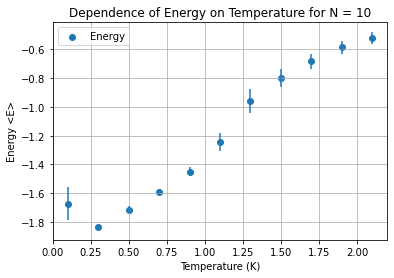

In [59]:
plt.scatter(T_arr[::-1], E_means_10,label="Energy")
plt.errorbar(T_arr[::-1], E_means_10, yerr=E_std_10, ls = "")
plt.grid()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Energy <E>")
plt.title("Dependence of Energy on Temperature for N = 10")
plt.savefig("energy_10.png")
# plt.savefig("energy_8.pgf")

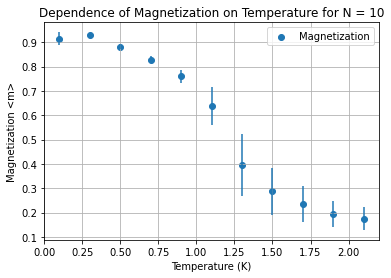

In [60]:
plt.scatter(T_arr[::-1],mag_means_10,label="Magnetization")
plt.errorbar(T_arr[::-1], mag_means_10, yerr=m_std_10,ls = "")
plt.grid()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Magnetization <m>")
plt.title("Dependence of Magnetization on Temperature for N = 10")
plt.savefig("mag_10.png")
# plt.savefig("mag_8.pgf")

[[Model]]
    Model(Lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 11
    # variables        = 3
    chi-square         = 0.58994387
    reduced chi-square = 0.07374298
    Akaike info crit   = -26.1818547
    Bayesian info crit = -24.9881689
[[Variables]]
    amp1:  1.95785117 +/- 0.26260866 (13.41%) (init = 0.25)
    cen1:  1.33566697 +/- 0.03700468 (2.77%) (init = 0.6)
    wid1:  0.26605822 +/- 0.05136867 (19.31%) (init = 0.15)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp1, wid1) = -0.697


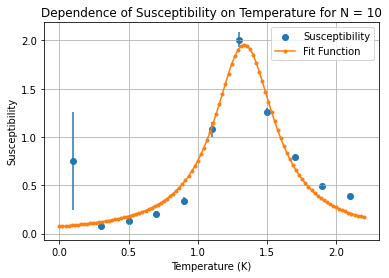

In [61]:

params_10 = gmodel.make_params(amp1=0.25, cen1=0.6, wid1=0.15)
result_10 = gmodel.fit(sus_10, params_10, x=T_arr[::-1])
print(result_10.fit_report())

beta_arr_cont= np.linspace(0,2.2,100)
fitted_func_10= Lorentzian(beta_arr_cont, result_10.params.valuesdict()['amp1'],
                         result_10.params.valuesdict()['cen1'],result_10.params.valuesdict()['wid1'])





plt.scatter(T_arr[::-1],sus_10,label="Susceptibility")
plt.errorbar(T_arr[::-1], sus_10, yerr=np.array(sus_10_std)/N**2,ls = "")
plt.plot(beta_arr_cont, fitted_func_10, '.-', label='Fit Function')

plt.grid()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Susceptibility")
plt.title("Dependence of Susceptibility on Temperature for N = 10")
plt.savefig("sus_10.png")
# plt.savefig("sus_8.pgf")

In [160]:
# T_arr_new= T_arr[::-1]
# params_10_heat = gmodel.make_params(amp1=1, cen1=1, wid1=1)
# result_10_heat = gmodel.fit(np.array(heat_10)[(T_arr_new>0.6)], params_10_heat, x=T_arr_new[T_arr_new>0.6])
# print(result_10_heat.fit_report())

# beta_arr_cont= np.linspace(0,2.2,100)
# fitted_func_10_heat= Lorentzian(beta_arr_cont, result_10_heat.params.valuesdict()['amp1'],
#                          result_10_heat.params.valuesdict()['cen1'],result_10_heat.params.valuesdict()['wid1'])






# plt.scatter(T_arr_new[T_arr_new>0.25],np.array(heat_10)[T_arr_new>0.25],label="Specific Heat")
# #plt.errorbar(T_arr[::-1], np.array(heat_10), yerr=np.array(heat_10_std)/N**2,ls = "")
# #plt.plot(beta_arr_cont, fitted_func_10_heat, '.-', label='Fit Function')
# #plt.ylim(0,2)
# plt.grid()
# plt.legend()
# plt.xlabel("Temperature (K)")
# plt.ylabel("Specific Heat")
# plt.title("Dependence of Specific Heat on Temperature for N = 10")
# plt.savefig("sp_heat_10.png")
# # plt.savefig("sp_heat_8.pgf")

[1.19362107 1.14890718 0.48352634]


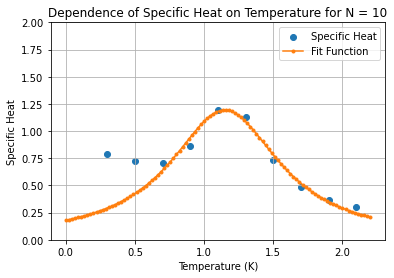

In [163]:
popt10, cov10= curve_fit(Lorentzian, T_arr_new[T_arr_new>0.6], np.array(heat_10)[T_arr_new>0.6])
print(popt10)

beta_arr_cont= np.linspace(0,2.2,100)
fitted_func_10_heat= Lorentzian(beta_arr_cont, popt10[0],
                         popt10[1],popt10[2])

plt.scatter(T_arr_new[T_arr_new>0.25],np.array(heat_10)[T_arr_new>0.25],label="Specific Heat")
plt.errorbar(T_arr[::-1], heat_10, yerr=np.array(heat_10_std)/N**2,ls = "")
plt.plot(beta_arr_cont, fitted_func_10_heat, '.-', label='Fit Function')
plt.ylim(0,2)
plt.grid()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Specific Heat")
plt.title("Dependence of Specific Heat on Temperature for N = 10")
plt.savefig("sp_heat_10.png")

# N = 12

In [64]:
N = 12
n_therm = 1000
bin_length = 30
L_i = np.array([[2*np.pi*np.random.uniform() for x in range(N)] for y in range(N)])
N_cfg = 200
N_md = 50
J = 1.0
T_arr = np.arange(0.1, 2.20, 0.20)
beta_arr=np.sort(1/T_arr)

E_means_12 = []
mag_means_12 = []

m_std_12 = []
E_std_12 = []

sus_12 = []
sus_12_std = []

heat_12 = []
heat_12_std = []

L_i = np.array([[2*np.pi*np.random.uniform() for x in range(N)] for y in range(N)])

for beta in beta_arr:
    mag_12,E_12,M2_arr_12, E2_arr_12 = markov_chain(L_i,N_cfg,N_md,beta,J)
    

    k_12 = np.mean(np.array(mag_12))
    en_12 = np.mean(np.array(E_12))
    E_means_12.append(en_12)
    mag_means_12.append(k_12)
    
    m_std_12.append(np.std(mag_12))
    E_std_12.append(np.std(E_12))
    sus_12.append((np.mean( M2_arr_12) - np.square(np.mean(mag_12)))*beta*N**2)
    sus_12_std.append(np.std( M2_arr_12 - np.square(mag_12)*beta*N**2))
    
    heat_12.append((np.mean(E2_arr_12) - np.square(np.mean(np.array(E_12))))*beta**2*N**2)
    heat_12_std.append(np.std((E2_arr_12 - np.array(E_12)**2)*beta**2*N**2))

    
    

Acceptance rate 0.9438333333333333
Acceptance rate 0.9383333333333334
Acceptance rate 0.9258333333333333
Acceptance rate 0.9311666666666667
Acceptance rate 0.9213333333333333
Acceptance rate 0.9091666666666667
Acceptance rate 0.8888333333333334
Acceptance rate 0.867
Acceptance rate 0.8523333333333334
Acceptance rate 0.8376666666666667
Acceptance rate 0.5381666666666667


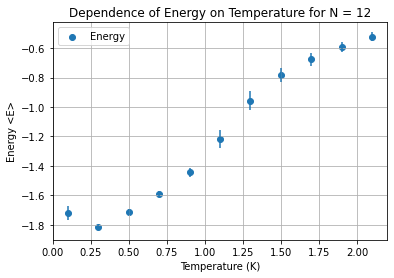

In [65]:
plt.scatter(T_arr[::-1], E_means_12,label="Energy")
plt.errorbar(T_arr[::-1], E_means_12, yerr=E_std_12, ls = "")
plt.grid()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Energy <E>")
plt.title("Dependence of Energy on Temperature for N = 12")
plt.savefig("energy_12.png")
# plt.savefig("energy_8.pgf")

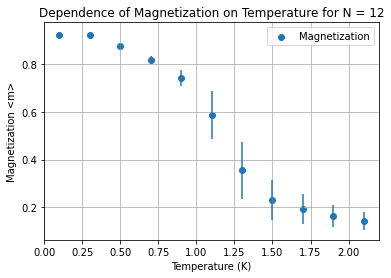

In [66]:
plt.scatter(T_arr[::-1],mag_means_12,label="Magnetization")
plt.errorbar(T_arr[::-1], mag_means_12, yerr=m_std_12,ls = "")
plt.grid()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Magnetization <m>")
plt.title("Dependence of Magnetization on Temperature for N = 12")
plt.savefig("mag_12.png")
# plt.savefig("mag_8.pgf")

In [168]:

params_12 = gmodel.make_params(amp1=2.51046094, cen1=1.2603391, wid1=0.25615602)
#result_12 = gmodel.fit(sus_12, params_12, x=T_arr[::-1])
# print(result_12.fit_report())

beta_arr_cont= np.linspace(0,2.2,100)
fitted_func_12= Lorentzian(beta_arr_cont, result_12.params.valuesdict()['amp1'],
                         result_12.params.valuesdict()['cen1'],result_12.params.valuesdict()['wid1'])





# plt.scatter(T_arr[::-1],sus_12,label="Susceptibility")
# plt.errorbar(T_arr[::-1], sus_12, yerr=np.array(sus_12_std)/N**2,ls = "")
# plt.plot(beta_arr_cont, fitted_func_12, '.-', label='Fit Function')
# plt.grid()
# plt.legend()
# plt.xlabel("Temperature (K)")
# plt.ylabel("Susceptibility")
# plt.title("Dependence of Susceptibility on Temperature for N = 12")
# plt.savefig("sus_12.png")
# plt.savefig("sus_8.pgf")

[2.51046094 1.2603391  0.25615602]


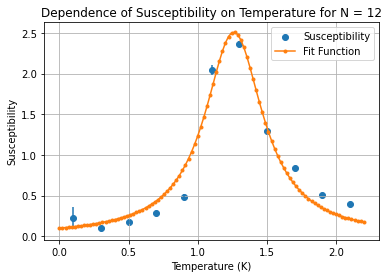

In [169]:
from scipy.optimize import curve_fit
popt, cov= curve_fit(Lorentzian, T_arr[::-1], sus_12)
print(popt)

beta_arr_cont= np.linspace(0,2.2,100)
fitted_func_12= Lorentzian(beta_arr_cont, popt[0],
                         popt[1],popt[2])

plt.scatter(T_arr[::-1],sus_12,label="Susceptibility")
plt.errorbar(T_arr[::-1], sus_12, yerr=np.array(sus_12_std)/N**2,ls = "")
plt.plot(beta_arr_cont, fitted_func_12, '.-', label='Fit Function')
plt.grid()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Susceptibility")
plt.title("Dependence of Susceptibility on Temperature for N = 12")
plt.savefig("sus_12.png")

In [164]:

# params_12_heat = gmodel.make_params(amp1=1.2, cen1=1, wid1=0.5)
# result_12_heat = gmodel.fit(np.array(heat_12)[T_arr_new>0.6], params_12_heat, x=T_arr_new[T_arr_new>0.6])
# print(result_12_heat.fit_report())

# beta_arr_cont= np.linspace(0,2.2,100)
# fitted_func_12_heat= Lorentzian(beta_arr_cont, result_12_heat.params.valuesdict()['amp1'],
#                          result_12_heat.params.valuesdict()['cen1'],result_12_heat.params.valuesdict()['wid1'])






# plt.scatter(T_arr_new[T_arr_new>0.25],np.array(heat_12)[T_arr_new>0.25],label="Specific Heat")
# #plt.errorbar(T_arr[::-1], heat_12, yerr=np.array(heat_12_std)/N**2,ls = "")
# plt.plot(beta_arr_cont, fitted_func_12_heat, '.-', label='Fit Function')
# #plt.ylim(0,2)
# plt.grid()
# plt.legend()
# plt.xlabel("Temperature (K)")
# plt.ylabel("Specific Heat")
# plt.title("Dependence of Specific Heat on Temperature for N = 12")
# plt.savefig("sp_heat_12.png")

[1.26270313 1.12073141 0.46215978]


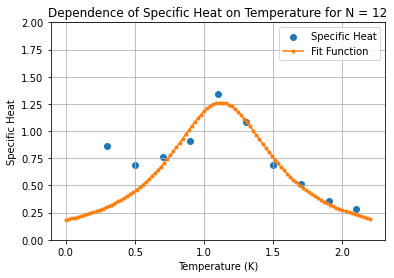

In [166]:
popt12, cov12= curve_fit(Lorentzian, T_arr_new[T_arr_new>0.6], np.array(heat_12)[T_arr_new>0.6])
print(popt12)

beta_arr_cont= np.linspace(0,2.2,100)
fitted_func_12_heat= Lorentzian(beta_arr_cont, popt12[0],
                         popt12[1],popt12[2])

plt.scatter(T_arr_new[T_arr_new>0.25],np.array(heat_12)[T_arr_new>0.25],label="Specific Heat")
plt.errorbar(T_arr[::-1], heat_12, yerr=np.array(heat_12_std)/N**2,ls = "")
plt.plot(beta_arr_cont, fitted_func_12_heat, '.-', label='Fit Function')
plt.ylim(0,2)
plt.grid()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Specific Heat")
plt.title("Dependence of Specific Heat on Temperature for N = 12")
plt.savefig("sp_heat_12.png")

# N = 15

In [71]:
N = 15
n_therm = 1000
bin_length = 30
L_i = np.array([[2*np.pi*np.random.uniform() for x in range(N)] for y in range(N)])
N_cfg = 200
N_md = 50
J = 1.0
T_arr = np.arange(0.1, 2.20, 0.20)
beta_arr=np.sort(1/T_arr)

E_means_15 = []
mag_means_15 = []

m_std_15 = []
E_std_15 = []

sus_15 = []
sus_15_std = []

heat_15 = []
heat_15_std = []

L_i = np.array([[2*np.pi*np.random.uniform() for x in range(N)] for y in range(N)])

for beta in beta_arr:
    mag_15,E_15,M2_arr_15, E2_arr_15 = markov_chain(L_i,N_cfg,N_md,beta,J)
    

    k_15 = np.mean(np.array(mag_15))
    en_15 = np.mean(np.array(E_15))
    E_means_15.append(en_15)
    mag_means_15.append(k_15)
    
    m_std_15.append(np.std(mag_15))
    E_std_15.append(np.std(E_15))
    sus_15.append((np.mean( M2_arr_15) - np.square(np.mean(mag_15)))*beta*N**2)
    sus_15_std.append(np.std( M2_arr_15 - np.square(mag_15)*beta*N**2))
    
    heat_15.append((np.mean(E2_arr_15) - np.square(np.mean(np.array(E_15))))*beta**2*N**2)
    heat_15_std.append(np.std((E2_arr_15 - np.array(E_15)**2)*beta**2*N**2))

    
    

Acceptance rate 0.931
Acceptance rate 0.9286666666666666
Acceptance rate 0.914
Acceptance rate 0.9041666666666667
Acceptance rate 0.9033333333333333
Acceptance rate 0.8945
Acceptance rate 0.8713333333333333
Acceptance rate 0.8516666666666667
Acceptance rate 0.8303333333333334
Acceptance rate 0.8343333333333334
Acceptance rate 0.6431666666666667


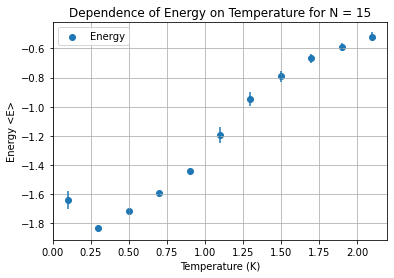

In [72]:
plt.scatter(T_arr[::-1], E_means_15,label="Energy")
plt.errorbar(T_arr[::-1], E_means_15, yerr=E_std_15, ls = "")
plt.grid()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Energy <E>")
plt.title("Dependence of Energy on Temperature for N = 15")
plt.savefig("energy_15.png")
# plt.savefig("energy_8.pgf")

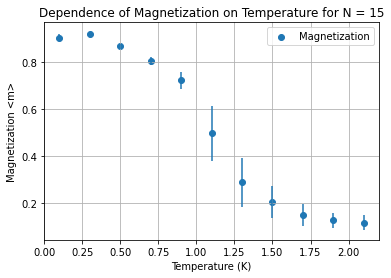

In [73]:
plt.scatter(T_arr[::-1],mag_means_15,label="Magnetization")
plt.errorbar(T_arr[::-1], mag_means_15, yerr=m_std_15,ls = "")
plt.grid()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Magnetization <m>")
plt.title("Dependence of Magnetization on Temperature for N = 15")
plt.savefig("mag_15.png")
# plt.savefig("mag_8.pgf")

[[Model]]
    Model(Lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 64
    # data points      = 11
    # variables        = 3
    chi-square         = 1.11570149
    reduced chi-square = 0.13946269
    Akaike info crit   = -19.1725312
    Bayesian info crit = -17.9788454
[[Variables]]
    amp1:  4.42738666 +/- 0.64453589 (14.56%) (init = 0.25)
    cen1:  1.17689519 +/- 0.01660219 (1.41%) (init = 0.6)
    wid1:  0.17173021 +/- 0.03464435 (20.17%) (init = 0.15)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp1, wid1) = -0.857
    C(amp1, cen1) = 0.363
    C(cen1, wid1) = -0.352


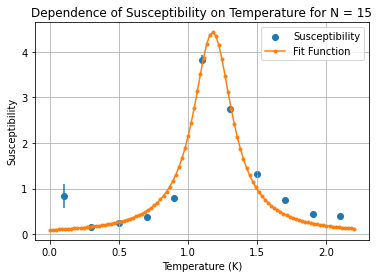

In [74]:

params_15 = gmodel.make_params(amp1=0.25, cen1=0.6, wid1=0.15)
result_15 = gmodel.fit(sus_15, params_15, x=T_arr[::-1])
print(result_15.fit_report())

beta_arr_cont= np.linspace(0,2.2,100)
fitted_func_15= Lorentzian(beta_arr_cont, result_15.params.valuesdict()['amp1'],
                         result_15.params.valuesdict()['cen1'],result_15.params.valuesdict()['wid1'])





plt.scatter(T_arr[::-1],sus_15,label="Susceptibility")
plt.errorbar(T_arr[::-1], sus_15, yerr=np.array(sus_15_std)/N**2,ls = "")
plt.plot(beta_arr_cont, fitted_func_15, '.-', label='Fit Function')
plt.grid()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Susceptibility")
plt.title("Dependence of Susceptibility on Temperature for N = 15")
plt.savefig("sus_15.png")
# plt.savefig("sus_8.pgf")

[1.33176926 1.11785944 0.41519371]


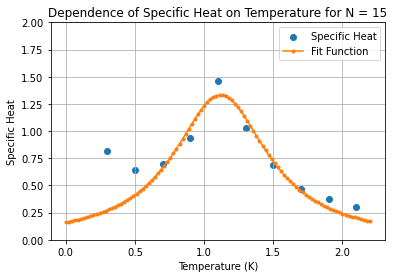

In [170]:
popt15, cov15= curve_fit(Lorentzian, T_arr_new[T_arr_new>0.6], np.array(heat_15)[T_arr_new>0.6])
print(popt15)

beta_arr_cont= np.linspace(0,2.2,100)
fitted_func_15_heat= Lorentzian(beta_arr_cont, popt15[0],
                         popt15[1],popt15[2])

plt.scatter(T_arr_new[T_arr_new>0.25],np.array(heat_15)[T_arr_new>0.25],label="Specific Heat")
plt.errorbar(T_arr[::-1], heat_15, yerr=np.array(heat_15_std)/N**2,ls = "")
plt.plot(beta_arr_cont, fitted_func_15_heat, '.-', label='Fit Function')
plt.ylim(0,2)
plt.grid()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Specific Heat")
plt.title("Dependence of Specific Heat on Temperature for N = 15")
plt.savefig("sp_heat_15.png")

# TRENDS

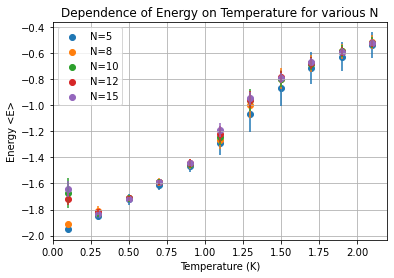

In [171]:
plt.scatter(T_arr[::-1], E_means_5,label="N=5")
plt.errorbar(T_arr[::-1], E_means_5, yerr=E_std_5, ls = "")

plt.scatter(T_arr[::-1], E_means_8,label="N=8")
plt.errorbar(T_arr[::-1], E_means_8, yerr=E_std_8, ls = "")

plt.scatter(T_arr[::-1], E_means_10,label="N=10")
plt.errorbar(T_arr[::-1], E_means_10, yerr=E_std_10, ls = "")

plt.scatter(T_arr[::-1], E_means_12,label="N=12")
plt.errorbar(T_arr[::-1], E_means_12, yerr=E_std_12, ls = "")

plt.scatter(T_arr[::-1], E_means_15,label="N=15")
plt.errorbar(T_arr[::-1], E_means_15, yerr=E_std_15, ls = "")

plt.grid()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Energy <E>")
plt.title("Dependence of Energy on Temperature for various N")
plt.savefig("energy_trend.png")



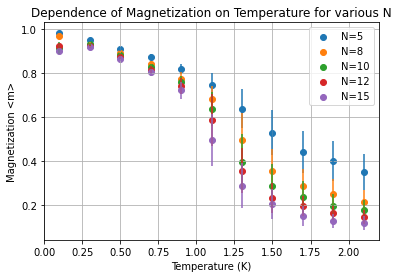

In [172]:
plt.scatter(T_arr[::-1],mag_means_5,label="N=5")
plt.errorbar(T_arr[::-1], mag_means_5, yerr=m_std_5,ls = "")

plt.scatter(T_arr[::-1],mag_means_8,label="N=8")
plt.errorbar(T_arr[::-1], mag_means_8, yerr=m_std_8,ls = "")

plt.scatter(T_arr[::-1],mag_means_10,label="N=10")
plt.errorbar(T_arr[::-1], mag_means_10, yerr=m_std_10,ls = "")

plt.scatter(T_arr[::-1],mag_means_12,label="N=12")
plt.errorbar(T_arr[::-1], mag_means_12, yerr=m_std_15,ls = "")


plt.scatter(T_arr[::-1],mag_means_15,label="N=15")
plt.errorbar(T_arr[::-1], mag_means_15, yerr=m_std_15,ls = "")

           
           
plt.grid()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Magnetization <m>")
plt.title("Dependence of Magnetization on Temperature for various N")
plt.savefig("mag_trend.png")

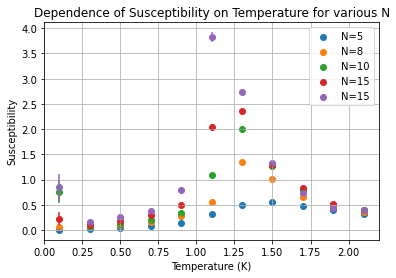

In [173]:
plt.scatter(T_arr[::-1],sus_5,label="N=5")
plt.errorbar(T_arr[::-1], sus_5, yerr=np.array(sus_5_std)/N**2,ls = "")

plt.scatter(T_arr[::-1],sus_8,label="N=8")
plt.errorbar(T_arr[::-1], sus_8, yerr=np.array(sus_8_std)/N**2,ls = "")

plt.scatter(T_arr[::-1],sus_10,label="N=10")
plt.errorbar(T_arr[::-1], sus_10, yerr=np.array(sus_10_std)/N**2,ls = "")

plt.scatter(T_arr[::-1],sus_12,label="N=15")
plt.errorbar(T_arr[::-1], sus_12, yerr=np.array(sus_12_std)/N**2,ls = "")


plt.scatter(T_arr[::-1],sus_15,label="N=15")
plt.errorbar(T_arr[::-1], sus_15, yerr=np.array(sus_15_std)/N**2,ls = "")


plt.grid()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Susceptibility")
plt.title("Dependence of Susceptibility on Temperature for various N")
plt.savefig("sus_trend.png")

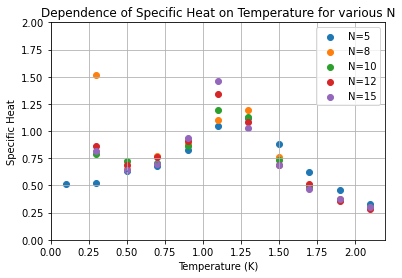

In [174]:
plt.scatter(T_arr[::-1],heat_5,label="N=5")
plt.errorbar(T_arr[::-1], heat_5, yerr=np.array(heat_5_std)/N**2,ls = "")

plt.scatter(T_arr[::-1],heat_8,label="N=8")
plt.errorbar(T_arr[::-1], heat_8, yerr=np.array(heat_8_std)/N**2,ls = "")

plt.scatter(T_arr[::-1],heat_10,label="N=10")
plt.errorbar(T_arr[::-1], heat_10, yerr=np.array(heat_10_std)/N**2,ls = "")

plt.scatter(T_arr[::-1],heat_12,label="N=12")
plt.errorbar(T_arr[::-1], heat_12, yerr=np.array(heat_12_std)/N**2,ls = "")

plt.scatter(T_arr[::-1],heat_15,label="N=15")
plt.errorbar(T_arr[::-1], heat_15, yerr=np.array(heat_15_std)/N**2,ls = "")

plt.grid()
plt.legend()
plt.ylim(0,2)
plt.xlabel("Temperature (K)")
plt.ylabel("Specific Heat")
plt.title("Dependence of Specific Heat on Temperature for various N")
plt.savefig("sp_heat_trend.png")